In [1]:
import pickle
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt 
from itertools import zip_longest    

In [2]:
G_df = pd.read_csv("../data/PathLinker_2018_human-ppi-weighted-cap0_75.txt",delimiter='\t')
G_df['cost'] = 1 / G_df['edge_weight'] #convert the probabilty to cose
G_df.head(15)

#tail    head  edge_weight  \
0   Q8TBF5  Q9UKB1     0.311133   
1   Q8TBF4  Q15717     0.311133   
2   Q8TBF4  P08865     0.311133   
3   Q8TBF4  Q02539     0.311133   
4   Q8TBF4  Q96J01     0.201461   
5   Q8TBF4  P51148     0.710749   
6   Q8TBF4  Q8NI27     0.201461   
7   Q8TBF4  Q15696     0.311133   
8   Q8TBF4  O43660     0.201461   
9   Q8TBF4  Q15527     0.311133   
10  Q8TBF4  P15880     0.311133   
11  Q8TBF4  Q9UGY1     0.311133   
12  Q8TBF4  Q96HE9     0.311133   
13  Q8TBF4  Q6I9Y2     0.201461   
14  Q8TBF4  Q8N5P1     0.311133   

                                            edge_type      cost  
0        MI:0004 (affinity chromatography technology)  3.214060  
1        MI:0004 (affinity chromatography technology)  3.214060  
2        MI:0004 (affinity chromatography technology)  3.214060  
3        MI:0004 (affinity chromatography technology)  3.214060  
4                               MI:0401 (biochemical)  4.963740  
5   MI:0007 (anti tag coimmunoprecipitation)|MI:00...  1.406966  
6                               MI:0401 (biochemical)  4.963740  
7        MI:0004 (affinity chromatography technology)  3.214060  
8                               MI:0401 (biochemical)  4.963740  
9        MI:0004 (affinity chromatography technology)  3.214060  
10       MI:0004 (affinity chromatography technology)  3.214060  
11       MI:0004 (affinity chromatography technology)  3.214060  
12       MI:0004 (affinity chromatography technology)  3.214060  
13                              MI:0401 (biochemical)  4.963740  
14       MI:0004 (affinity chromatography technology)  3.214060

In [3]:
G = nx.from_pandas_edgelist(G_df, source='#tail',target='head', edge_attr=['edge_weight','edge_type','cost'],create_using=nx.DiGraph())
#G.edges(data=True)

In [4]:
print(G)
print(f"DiGraph density = {nx.density(G)}")
print("Triadic closure:", nx.transitivity(G))

DiGraph with 17168 nodes and 612516 edges
DiGraph density = 0.002078276495612885
Triadic closure: 0.06446546978382366


### plot degree distribution of the given graph

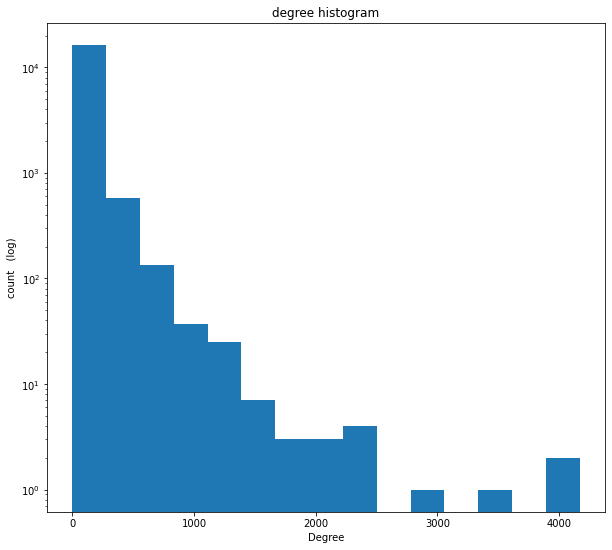

In [10]:
def degree_dist(G:nx.DiGraph,save_degree:bool=True):
    """plot histogram of a graph degrees
    
    Args:
        G (nx.DiGraph)
        save_degree (bool, optional): wheather to save each node degree in a text file. Defaults to True.
    """
    plt.figure(figsize=(10,9))
    degrees = [G.degree(n) for n in G.nodes()] # get nodes degree 
    if save_degree:
        with open("degrees.txt",'w') as f:
            # rank on degree, descending order 
            for node, degree in sorted(zip(G.nodes(),degrees),key=lambda t: t[1],reverse=True):
                f.write(f"{node}\t{degree}\n")
    plt.hist(degrees,bins=15)
    plt.yscale('log')
    plt.title("degree histogram")
    plt.ylabel("count   (log)")
    plt.xlabel("Degree")
    plt.show()

    
degree_dist(G,save_degree=True)

In [5]:
def shortest_paths(G,n1,n2,weight='cost'):
    # empty graph to store paths between the 2 nodes
    empty_graph = nx.DiGraph()
    # create a file in the current working directory to store paths as described in the requirements 
    with open("shortest_paths.txt",'w') as f:
        # find all shortest paths between the 2 nodes 
        all_shortest_paths = (nx.all_shortest_paths(G,n1,n2,weight=weight,method='dijkstra'))
        #get the cost of the found shorest path
        path_score = 1 # initial path score
        for path in all_shortest_paths:
            f.write(f"found path {path}\n")
            edges = list(zip_longest(path,path[1:]))[:-1] # syntax to convert 
            for edge in edges :
                e_weight = 1 / G.get_edge_data(edge[0],edge[1])[weight] #convert from cost to probabilty 
                path_score *= e_weight #multiply by every edge probabilty
                empty_graph.add_edge(edge[0],edge[1],score=e_weight)
                f.write(f" edge {edge} has weight  = {e_weight} \n")
            f.write(f"Path score = {path_score}")
    plt.figure(figsize=(10,9))
    labels = nx.get_edge_attributes(empty_graph,'score')
    pos = nx.spring_layout(empty_graph)
    nx.draw_networkx(empty_graph,pos)
    nx.draw_networkx_edge_labels(empty_graph,pos=pos,edge_labels = labels )
    plt.title(f'path from node {n1} to node {n2} cost {path_score}')
    plt.show()


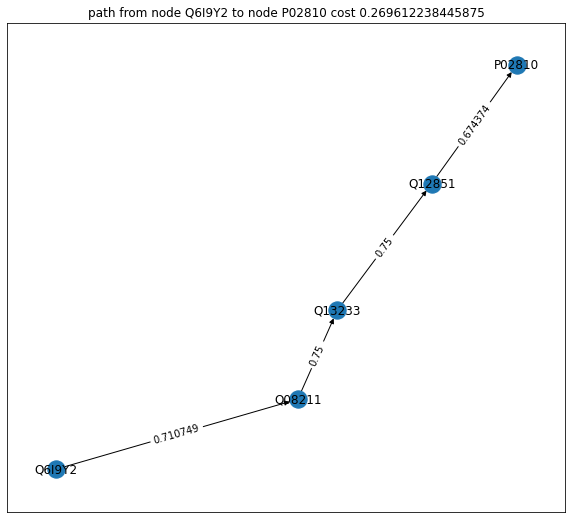

In [6]:
shortest_paths(G,'Q6I9Y2','P02810',weight='cost')

In [35]:
def find_neighbors(G:nx.DiGraph,n:str,weight='edge_weight'):
    """get all the nodes connected to the given node

    Args:
        G (nx.DiGraph): _description_
        n (str): _description_
        weight (str, optional): _description_. Defaults to 'edge_weight'.
    """

    with open("neighbors.txt",'w')  as f:
        # find previous nodes
        predecessors = list(G.predecessors(n))
        # find next nodes
        successors = list(G.successors(n))
        # get node degree 
        f.write(f"protien {n} has {len(predecessors) + len(successors)} neighbors\n")
        # empty graph to store connected edges 
        empty_graph = nx.DiGraph()
        for node in predecessors:
            # store in file
            f.write(f"{node} -> {n} {G.get_edge_data(node,n)[weight]}\n")
            # add to the empty graph
            empty_graph.add_edge(node,n,score=G.get_edge_data(node,n)[weight])
        for node in successors:
            # add to the empty graph
            empty_graph.add_edge(n,node,score=G.get_edge_data(n,node)[weight])
            # store in file
            f.write(f"{n} -> {node} {G.get_edge_data(n,node)[weight]}\n")
    plt.figure(figsize=(15,12))
    labels = nx.get_edge_attributes(empty_graph,'score')
    pos = nx.circular_layout(empty_graph)
    plt.title(f"out-degree/in-degree for node {n} = {G.out_degree(n)}/{G.in_degree(n)}")
    nx.draw_networkx(empty_graph,pos)
    nx.draw_networkx_edge_labels(empty_graph,pos=pos,edge_labels = labels )
    plt.show()

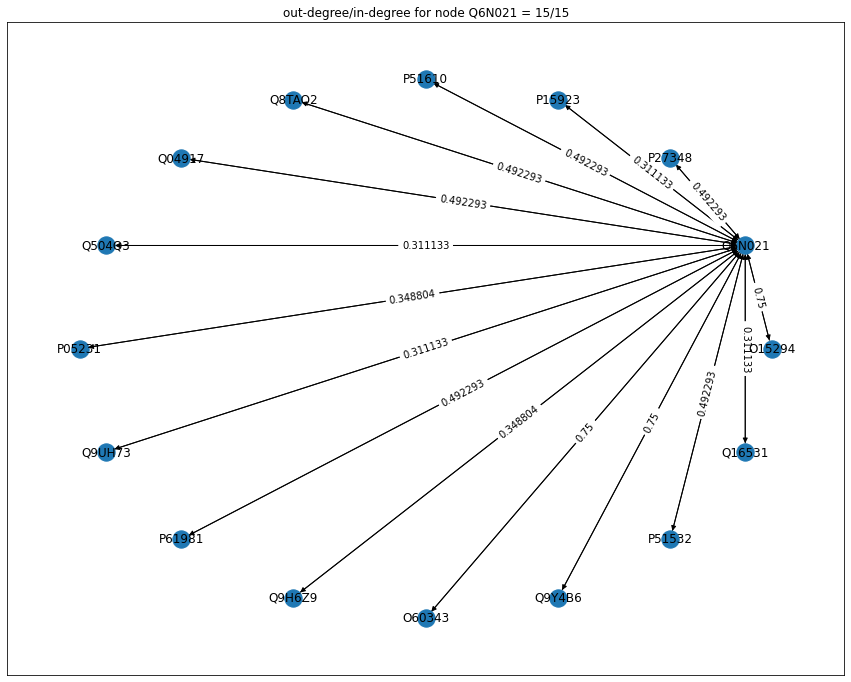

In [38]:
find_neighbors(G,'Q6N021')

In [7]:
def to_adj_matrix(G:nx.DiGraph):
    # convert the DiGraph to un-directed
    G = nx.to_undirected(G)
    G_matrix = nx.to_pandas_adjacency(G)
    with open('adj_matrix.pickle','wb') as f:
        #save in a pickle file
        pickle.dump(G_matrix,f)
to_adj_matrix(G=G)